# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Importing Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime
import matplotlib.pyplot as plt 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('C:/Users/mfardhossein/Documents/Udacity/capstone/starbucks/star/data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('C:/Users/mfardhossein/Documents/Udacity/capstone/starbucks/star/data/profile.json', orient='records', lines=True)
transcript = pd.read_json('C:/Users/mfardhossein/Documents/Udacity/capstone/starbucks/star/data/transcript.json', orient='records', lines=True)

# Data Exploration

## 1.portfolio

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


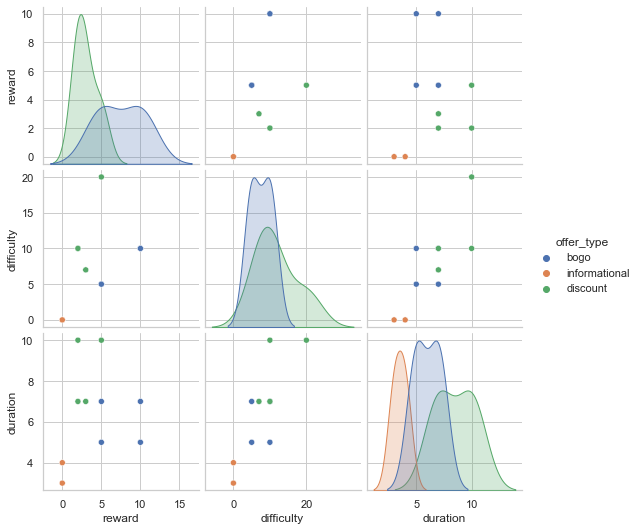

In [4]:
#Checking the relationship between variables in portfolio
sns.set_theme(style="whitegrid")
sns.pairplot(portfolio, hue= 'offer_type' )

In [5]:
#shape of portfolio
portfolio.shape

(10, 6)

In [6]:
#Checking the dificulty variable
portfolio['difficulty'].value_counts()

10    4
5     2
0     2
7     1
20    1
Name: difficulty, dtype: int64

In [7]:
#Checking the duration variable
portfolio['duration'].value_counts()

7     4
10    2
5     2
4     1
3     1
Name: duration, dtype: int64

In [8]:
#Checking the offer_type variable
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [9]:
#Types of the portfoilio variables
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


## 2.profile

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
#The shape of profile
profile.shape

(17000, 5)

In [12]:
#Checking the nan variable
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

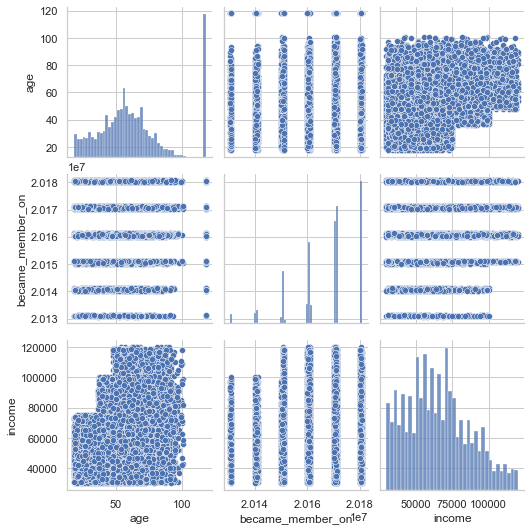

In [13]:
#Checking the relationship between variables in profile using pairplot
sns.set_theme(style="whitegrid")
sns.pairplot(profile)

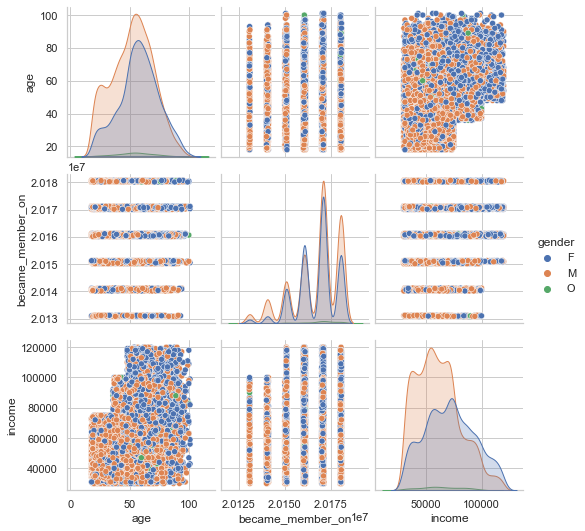

In [14]:
#Checking the relationship between variables in profile using pairplot considering the gender
sns.pairplot(profile, hue="gender")

Text(0.5, 1.0, 'Gender')

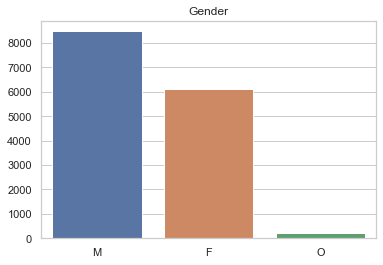

In [15]:

#Overal distribution of the gender
sns.barplot(x=profile['gender'].value_counts().index, y=profile['gender'].value_counts().values, data=profile)
plt.title('Gender')

In [16]:
#Checking the gender variable
profile['gender'].value_counts()


M    8484
F    6129
O     212
Name: gender, dtype: int64

Text(0.5, 1.0, 'Income')

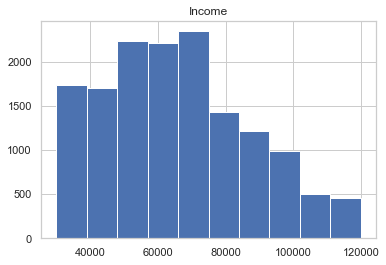

In [17]:
#Checking the income variable
profile['income'].hist()
plt.title('Income')

Text(0.5, 1.0, 'Age')

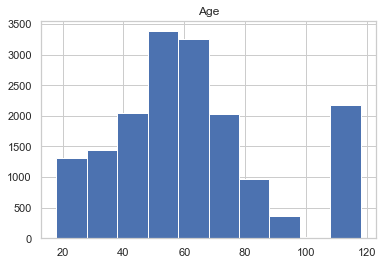

In [18]:
#Checking the age variable
profile['age'].hist()
plt.title('Age')

In [19]:
#Checking the age variable
(profile['age'].value_counts())


118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [20]:
# Noticing that there are more than 2000 rows with the age 118
profile[profile.age == 118][['gender','age','income']]

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


## 3.transcript

In [21]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [22]:
#Types of the transcript dataframes
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [23]:
# shape of transcript
transcript.shape

(306534, 4)

In [24]:
#number of nan values in transcript
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [25]:
#Status of offers
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Text(0.5, 1.0, 'event')

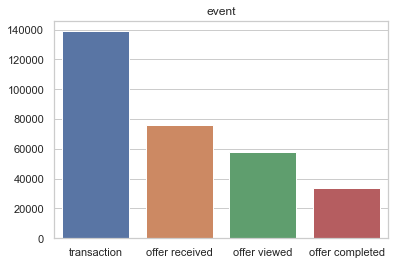

In [26]:
#Overal distribution of the offers
sns.barplot(x=transcript['event'].value_counts().index, y=transcript['event'].value_counts().values, data=profile)
plt.title('event')

# Data Cleaning

## 1.Portfolio

In [27]:
#Portfolio
portfolio_cleaning = portfolio.copy()
portfolio_cleaning

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [28]:
#counting the offer_type
portfolio_cleaning.groupby("offer_type")["id"].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [29]:
#Changing the name id to offer_id
portfolio_cleaning.rename(columns={"id" :"offer_id"},inplace=True)

In [30]:
#Checking the channels columns
portfolio_cleaning['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [31]:
#Creating dummy variables for the values contained in channel
portfolio_cleaning['email']=portfolio_cleaning['channels'].apply(lambda x: 1 if 'email' in x else 0 )
portfolio_cleaning["email"]=portfolio_cleaning["email"].astype('category')
portfolio_cleaning['mobile']=portfolio_cleaning['channels'].apply(lambda x: 1 if 'mobile' in x else 0 )
portfolio_cleaning["mobile"]=portfolio_cleaning["mobile"].astype('category')
portfolio_cleaning['social']=portfolio_cleaning['channels'].apply(lambda x: 1 if 'social' in x else 0 )
portfolio_cleaning["social"]=portfolio_cleaning["social"].astype('category')
portfolio_cleaning['web']=portfolio_cleaning['channels'].apply(lambda x: 1 if 'web' in x else 0 )
portfolio_cleaning["web"]=portfolio_cleaning["web"].astype('category')

In [32]:
#removing the channel column
portfolio_cleaning.drop('channels', axis=1, inplace=True)
portfolio_cleaning

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [33]:
#turning the offer_type to categorical variables
portfolio_cleaning["offer_type"]=portfolio_cleaning["offer_type"].astype('category')
portfolio_cleaning["offer_type"] = portfolio_cleaning["offer_type"].cat.codes
portfolio_cleaning["offer_type"]=portfolio_cleaning["offer_type"].astype('category')

In [34]:
portfolio_cleaning

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,0,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,2,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,1,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,1,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,2,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,0,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,1,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [35]:
#types of the cleaned portfolio 
portfolio_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   reward      10 non-null     int64   
 1   difficulty  10 non-null     int64   
 2   duration    10 non-null     int64   
 3   offer_type  10 non-null     category
 4   offer_id    10 non-null     object  
 5   email       10 non-null     category
 6   mobile      10 non-null     category
 7   social      10 non-null     category
 8   web         10 non-null     category
dtypes: category(5), int64(3), object(1)
memory usage: 978.0+ bytes


## 2. Profile

In [36]:
profile_cleaning = profile.copy()

In [37]:
profile_cleaning

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [38]:
#changing the id to customer_id 
profile_cleaning.rename(columns={"id" :"customer_id"},inplace=True)

In [39]:
profile_cleaning

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [40]:
#types of tehe profile_cleaning
profile_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   customer_id       17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [41]:
#taking the year, month and days out of the member column

profile_cleaning['became_member_on'] = pd.to_datetime(profile_cleaning['became_member_on'], format = '%Y%m%d')
profile_cleaning['members_year'] = profile_cleaning['became_member_on'].dt.year
profile_cleaning['members_month'] = profile_cleaning['became_member_on'].dt.month
profile_cleaning['members_day'] = profile_cleaning['became_member_on'].dt.day

In [42]:
#measuring the duration columns and creating a separate column for that
profile_cleaning['duration_days'] = datetime.datetime.today().date() - profile_cleaning['became_member_on'].dt.date
profile_cleaning['duration_days'] = profile_cleaning['duration_days'].dt.days


In [43]:
profile_cleaning

,gender,age,customer_id,became_member_on,income,members_year,members_month,members_day,duration_days
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12,1503
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,1350
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12,988
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9,1417
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4,1330
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6,4,1026
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7,13,987
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1,26,1520
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3,7,1845


In [44]:
#Identifying the rows  having an age equal to 118
profile_cleaning[profile_cleaning['age']==118]

,gender,age,customer_id,became_member_on,income,members_year,members_month,members_day,duration_days
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12,1503
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12,988
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4,1330
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25,1278
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2,1271
...,...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1,1667
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15,1806
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5,1117
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16,1896


In [45]:
#Turning this age to Nan
profile_cleaning['age']= profile_cleaning['age'].apply(lambda x : np.nan if x==118 else x)

In [46]:
#checking weather the 118 age became nan
profile_cleaning['age'].isnull().sum()

2175

In [47]:
#removing all Nans
profile_cleaning.dropna(inplace=True)

In [48]:
#Checking nulls in the columns
profile_cleaning.isnull().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
members_year        0
members_month       0
members_day         0
duration_days       0
dtype: int64

In [49]:
#removing the became_member_on column
profile_cleaning= profile_cleaning.drop(['became_member_on'],axis=1)

In [50]:
profile_cleaning.head()

,gender,age,customer_id,income,members_year,members_month,members_day,duration_days
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1350
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1417
5,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,1065
8,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,1141
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,1231


In [51]:
#Labeling the gender column
profile_cleaning["gender"]=profile_cleaning["gender"].astype('category')
profile_cleaning["gender"] = profile_cleaning["gender"].cat.codes

In [52]:
profile_cleaning

,gender,age,customer_id,income,members_year,members_month,members_day,duration_days
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1350
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1417
5,1,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,1065
8,1,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,1141
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,1231
...,...,...,...,...,...,...,...,...
16995,0,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,2018,6,4,1026
16996,1,61.0,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,2018,7,13,987
16997,1,49.0,01d26f638c274aa0b965d24cefe3183f,73000.0,2017,1,26,1520
16998,0,83.0,9dc1421481194dcd9400aec7c9ae6366,50000.0,2016,3,7,1845


In [53]:
profile_cleaning.describe()

,gender,age,income,members_year,members_month,members_day,duration_days
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.600877,54.393524,65404.991568,2016.620169,6.695582,15.904013,1496.478988
std,0.518114,17.383705,21598.299410,1.198245,3.488853,8.747571,419.205158
min,0.000000,18.000000,30000.000000,2013.000000,1.000000,1.000000,974.000000
25%,0.000000,42.000000,49000.000000,2016.000000,4.000000,8.000000,1182.000000
50%,1.000000,55.000000,64000.000000,2017.000000,7.000000,16.000000,1332.000000
75%,1.000000,66.000000,80000.000000,2017.000000,10.000000,23.000000,1771.000000
max,2.000000,101.000000,120000.000000,2018.000000,12.000000,31.000000,2797.000000


In [54]:
#Creating an age_category column
profile_cleaning['age_category']=pd.cut(profile_cleaning['age'], bins=[17,40, 60, 103],labels=['young', 'adult', 'senior'])

In [55]:
#Turning the age category to categorical type
profile_cleaning["age_category"]=profile_cleaning["age_category"].astype('category')
profile_cleaning["age_category"] = profile_cleaning["age_category"].cat.codes

In [56]:
#Creating dummy variable sof the age based on the decades
profile_cleaning['age_decade']=pd.cut(profile_cleaning['age'], bins=[17,20,30,40,50,60,70,80,90,100, 103],labels=['Less_20', '20s', '30s','40s', '50s', '60s','70s', '80s', '90s','over_100'])

In [57]:
profile_cleaning.head()

,gender,age,customer_id,income,members_year,members_month,members_day,duration_days,age_category,age_decade
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1350,1,50s
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1417,2,70s
5,1,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,1065,2,60s
8,1,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,1141,2,60s
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,1231,1,50s


In [58]:
#Putting in each age_decade in a separate column
profile_cleaning = pd.concat([profile_cleaning.drop('age_decade', axis=1), pd.get_dummies(profile_cleaning['age_decade'], prefix='age_decade', prefix_sep='_')], axis=1)

In [59]:
profile_cleaning

,gender,age,customer_id,income,members_year,members_month,members_day,duration_days,age_category,age_decade_Less_20,age_decade_20s,age_decade_30s,age_decade_40s,age_decade_50s,age_decade_60s,age_decade_70s,age_decade_80s,age_decade_90s,age_decade_over_100
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1350,1,0,0,0,0,1,0,0,0,0,0
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1417,2,0,0,0,0,0,0,1,0,0,0
5,1,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,1065,2,0,0,0,0,0,1,0,0,0,0
8,1,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,1141,2,0,0,0,0,0,1,0,0,0,0
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,1231,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,0,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,2018,6,4,1026,1,0,0,0,1,0,0,0,0,0,0
16996,1,61.0,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,2018,7,13,987,2,0,0,0,0,0,1,0,0,0,0
16997,1,49.0,01d26f638c274aa0b965d24cefe3183f,73000.0,2017,1,26,1520,1,0,0,0,1,0,0,0,0,0,0
16998,0,83.0,9dc1421481194dcd9400aec7c9ae6366,50000.0,2016,3,7,1845,2,0,0,0,0,0,0,0,1,0,0


In [60]:
#creating a income category column
profile_cleaning['income_category']=pd.cut(profile_cleaning['income'], bins=[29999,60000, 80000, 120000],labels=['low-income', 'average-income', 'high-income'])

In [61]:
#Turning the created column to a categorical one
profile_cleaning["income_category"]=profile_cleaning["income_category"].astype('category')
profile_cleaning["income_category"] = profile_cleaning["income_category"].cat.codes

In [62]:
#Creating a column diving the rows based on every 10 thounds in the incomes
profile_cleaning['income_thousands']=pd.cut(profile_cleaning['income'], bins=[29999,39999,49999,59999,69999,79999,89999,99999,109999,120000],labels=['30th', '40th', '50th', '60th','70th', '80th', '90th', '100th','110th'])

In [63]:
#creating a dummy variable from the income_thousands
profile_cleaning = pd.concat([profile_cleaning.drop('income_thousands', axis=1), pd.get_dummies(profile_cleaning['income_thousands'], prefix='income_thousands', prefix_sep='_')], axis=1)

In [64]:
profile_cleaning

,gender,age,customer_id,income,members_year,members_month,members_day,duration_days,age_category,age_decade_Less_20,...,income_category,income_thousands_30th,income_thousands_40th,income_thousands_50th,income_thousands_60th,income_thousands_70th,income_thousands_80th,income_thousands_90th,income_thousands_100th,income_thousands_110th
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1350,1,0,...,2,0,0,0,0,0,0,0,0,1
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1417,2,0,...,2,0,0,0,0,0,0,0,1,0
5,1,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,1065,2,0,...,1,0,0,0,0,1,0,0,0,0
8,1,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,1141,2,0,...,0,0,0,1,0,0,0,0,0,0
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,1231,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,0,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,2018,6,4,1026,1,0,...,0,0,0,1,0,0,0,0,0,0
16996,1,61.0,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,2018,7,13,987,2,0,...,1,0,0,0,0,1,0,0,0,0
16997,1,49.0,01d26f638c274aa0b965d24cefe3183f,73000.0,2017,1,26,1520,1,0,...,1,0,0,0,0,1,0,0,0,0
16998,0,83.0,9dc1421481194dcd9400aec7c9ae6366,50000.0,2016,3,7,1845,2,0,...,0,0,0,1,0,0,0,0,0,0


In [65]:
#checking the type of profile_cleaning
profile_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  14825 non-null  int8   
 1   age                     14825 non-null  float64
 2   customer_id             14825 non-null  object 
 3   income                  14825 non-null  float64
 4   members_year            14825 non-null  int64  
 5   members_month           14825 non-null  int64  
 6   members_day             14825 non-null  int64  
 7   duration_days           14825 non-null  int64  
 8   age_category            14825 non-null  int8   
 9   age_decade_Less_20      14825 non-null  uint8  
 10  age_decade_20s          14825 non-null  uint8  
 11  age_decade_30s          14825 non-null  uint8  
 12  age_decade_40s          14825 non-null  uint8  
 13  age_decade_50s          14825 non-null  uint8  
 14  age_decade_60s          14825 non-null

## 3. transcript

In [66]:
transcript_cleaning=transcript.copy()

In [67]:
transcript_cleaning.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [68]:
#changing person to customer_id
transcript_cleaning.rename(columns={"person": "customer_id"},inplace=True)

In [69]:
transcript_cleaning.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [70]:
#getting all the values in the value column
val=[]
keys=[]
for i, r in transcript_cleaning.iterrows():
    for j in r['value']:
        keys.append(j)

In [71]:
#get the unique values from the value column
keys_value=list(set(keys))

In [72]:
keys_value

['reward', 'offer id', 'amount', 'offer_id']

In [73]:
#creating empty columns
transcript_cleaning['offer_id']=''
transcript_cleaning['amount']=0
transcript_cleaning['reward']=0

In [74]:
#filling the columns based on value column
for i,row in transcript_cleaning.iterrows():
    for j in row['value']:
        if j == 'offer_id' or j == 'offer id':
            transcript_cleaning.at[i,'offer_id'] = row['value'][j]
        elif j == 'amount':
            transcript_cleaning.at[i,'amount'] = row['value'][j]
        elif j == 'reward':
            transcript_cleaning.at[i,'reward'] = row['value'][j]
    
            

In [75]:
transcript_cleaning.head()

,customer_id,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [76]:
#checking the new created columns
transcript_cleaning[transcript_cleaning['amount'] !=0]

,customer_id,event,value,time,offer_id,amount,reward
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,,34,0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,,13,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,,19,0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,,18,0
12678,629fc02d56414d91bca360decdfa9288,transaction,{'amount': 33.9},0,,33,0
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,,1,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,,9,0
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,,3,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,,3,0


In [77]:
#checking the new created columns
transcript_cleaning[transcript_cleaning['offer_id'] ==''].count()

customer_id    138953
event          138953
value          138953
time           138953
offer_id       138953
amount         138953
reward         138953
dtype: int64

In [78]:
#searching for empty values and turning them to N/A
transcript_cleaning['offer_id']=transcript_cleaning['offer_id'].apply(lambda x:'N/A' if x=='' else x)

In [79]:
#checking the N/As
transcript_cleaning[transcript_cleaning['offer_id'] =='N/A'].count()

customer_id    138953
event          138953
value          138953
time           138953
offer_id       138953
amount         138953
reward         138953
dtype: int64

In [80]:
#removing the value column
transcript_cleaning.drop(['value'], axis=1, inplace=True)

In [81]:
transcript_cleaning.head()

,customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [82]:
#Checking the event
transcript_cleaning['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [83]:
#transcript_cleaning= transcript_cleaning[(transcript_cleaning['event']== 'offer viewed') | (transcript_cleaning['event']== 'offer completed')|(transcript_cleaning['event']== 'offer received') ]

In [84]:
transcript_cleaning.head()

,customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [85]:
#categorizing the event into 1 if offer is completed and 0 otherwise
transcript_cleaning['event']=transcript_cleaning['event'].apply(lambda x: 1 if 'offer completed' in x else 0 )

In [86]:
#Turning its type to category
transcript_cleaning["event"]=transcript_cleaning["event"].astype('category')

In [87]:
transcript_cleaning.head()

,customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [88]:
#checking the types of transcript
transcript_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   customer_id  306534 non-null  object  
 1   event        306534 non-null  category
 2   time         306534 non-null  int64   
 3   offer_id     306534 non-null  object  
 4   amount       306534 non-null  int64   
 5   reward       306534 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 12.0+ MB


# Combining the Three DataFrame

In [89]:
#merging the dataframes
df_all=transcript_cleaning.merge(portfolio_cleaning, how='left', on= "offer_id").merge(profile_cleaning, on= "customer_id" )

In [90]:
df_all.head()

,customer_id,event,time,offer_id,amount,reward_x,reward_y,difficulty,duration,offer_type,...,income_category,income_thousands_30th,income_thousands_40th,income_thousands_50th,income_thousands_60th,income_thousands_70th,income_thousands_80th,income_thousands_90th,income_thousands_100th,income_thousands_110th
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,0,132,N/A,19,0,NaN,NaN,NaN,NaN,...,2,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,1,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
4,78afa995795e4d85b5d9ceeca43f5fef,0,144,N/A,17,0,NaN,NaN,NaN,NaN,...,2,0,0,0,0,0,0,0,1,0


In [91]:
df_all.shape

(272762, 42)

In [92]:
#Checking the null
df_all.isnull().sum()

customer_id                    0
event                          0
time                           0
offer_id                       0
amount                         0
reward_x                       0
reward_y                  123957
difficulty                123957
duration                  123957
offer_type                123957
email                     123957
mobile                    123957
social                    123957
web                       123957
gender                         0
age                            0
income                         0
members_year                   0
members_month                  0
members_day                    0
duration_days                  0
age_category                   0
age_decade_Less_20             0
age_decade_20s                 0
age_decade_30s                 0
age_decade_40s                 0
age_decade_50s                 0
age_decade_60s                 0
age_decade_70s                 0
age_decade_80s                 0
age_decade

In [93]:
#imputing, using the mode as all the variable are categorical
'''
# Mean function
fill_mod = lambda col: col.fillna(col.mode()[0])
# Fill the mean
df_all = df_all.apply(fill_mod, axis=0)
'''

'\n# Mean function\nfill_mod = lambda col: col.fillna(col.mode()[0])\n# Fill the mean\ndf_all = df_all.apply(fill_mod, axis=0)\n'

In [94]:
#removing the nans
df_all=df_all.dropna(how='any',axis=0)

In [95]:
#checking the nulls
df_all.isnull().sum()

customer_id               0
event                     0
time                      0
offer_id                  0
amount                    0
reward_x                  0
reward_y                  0
difficulty                0
duration                  0
offer_type                0
email                     0
mobile                    0
social                    0
web                       0
gender                    0
age                       0
income                    0
members_year              0
members_month             0
members_day               0
duration_days             0
age_category              0
age_decade_Less_20        0
age_decade_20s            0
age_decade_30s            0
age_decade_40s            0
age_decade_50s            0
age_decade_60s            0
age_decade_70s            0
age_decade_80s            0
age_decade_90s            0
age_decade_over_100       0
income_category           0
income_thousands_30th     0
income_thousands_40th     0
income_thousands_50t

In [96]:
df_all

,customer_id,event,time,offer_id,amount,reward_x,reward_y,difficulty,duration,offer_type,...,income_category,income_thousands_30th,income_thousands_40th,income_thousands_50th,income_thousands_60th,income_thousands_70th,income_thousands_80th,income_thousands_90th,income_thousands_100th,income_thousands_110th
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,1,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
5,78afa995795e4d85b5d9ceeca43f5fef,0,168,5a8bc65990b245e5a138643cd4eb9837,0,0,0.0,0.0,3.0,2,...,2,0,0,0,0,0,0,0,1,0
6,78afa995795e4d85b5d9ceeca43f5fef,0,216,5a8bc65990b245e5a138643cd4eb9837,0,0,0.0,0.0,3.0,2,...,2,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,9fcbff4f8d7241faa4ab8a9d19c8a812,0,504,3f207df678b143eea3cee63160fa8bed,0,0,0.0,0.0,4.0,2,...,2,0,0,0,0,0,0,1,0,0
272758,9fcbff4f8d7241faa4ab8a9d19c8a812,0,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10.0,10.0,5.0,0,...,2,0,0,0,0,0,0,1,0,0
272759,9fcbff4f8d7241faa4ab8a9d19c8a812,0,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10.0,10.0,5.0,0,...,2,0,0,0,0,0,0,1,0,0
272760,3045af4e98794a04a5542d3eac939b1f,0,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10.0,10.0,5.0,0,...,1,0,0,0,0,1,0,0,0,0


In [97]:
#types of the merged data frame
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 272761
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   customer_id             148805 non-null  object  
 1   event                   148805 non-null  category
 2   time                    148805 non-null  int64   
 3   offer_id                148805 non-null  object  
 4   amount                  148805 non-null  int64   
 5   reward_x                148805 non-null  int64   
 6   reward_y                148805 non-null  float64 
 7   difficulty              148805 non-null  float64 
 8   duration                148805 non-null  float64 
 9   offer_type              148805 non-null  category
 10  email                   148805 non-null  category
 11  mobile                  148805 non-null  category
 12  social                  148805 non-null  category
 13  web                     148805 non-null  category
 14  gend

# Exploratory Data Analysis

,time,amount,reward_x,reward_y,difficulty,duration,gender,age,income,members_year,...,income_category,income_thousands_30th,income_thousands_40th,income_thousands_50th,income_thousands_60th,income_thousands_70th,income_thousands_80th,income_thousands_90th,income_thousands_100th,income_thousands_110th
time,1.000000,NaN,0.094675,0.005320,0.023295,0.025480,-0.005245,0.006074,0.004389,-0.006465,...,0.005020,-0.000613,-0.003308,0.000364,-0.003714,-0.000786,0.004704,0.004211,0.001425,-0.000761
amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reward_x,0.094675,NaN,1.000000,0.288494,0.139525,0.043352,-0.051978,0.034434,0.080971,-0.049093,...,0.074516,-0.045885,-0.037607,-0.015020,-0.007878,0.019461,0.031738,0.029917,0.025734,0.027804
reward_y,0.005320,NaN,0.288494,1.000000,0.421174,0.043448,-0.011536,0.000911,0.014786,-0.000117,...,0.013928,-0.000664,-0.005466,-0.007044,-0.010211,0.006411,0.004902,0.004547,0.005894,0.011280
difficulty,0.023295,NaN,0.139525,0.421174,1.000000,0.766816,-0.011374,0.009898,0.026340,-0.008276,...,0.025823,-0.013704,-0.010103,-0.007244,-0.008214,0.009352,0.017981,0.006227,0.008032,0.006489
duration,0.025480,NaN,0.043352,0.043448,0.766816,1.000000,-0.003713,0.006579,0.015368,-0.013612,...,0.017091,-0.005346,-0.008713,-0.007446,-0.001926,0.005477,0.014588,0.000522,0.004980,0.002678
gender,-0.005245,NaN,-0.051978,-0.011536,-0.011374,-0.003713,1.000000,-0.133512,-0.203188,-0.013042,...,-0.185586,0.088999,0.084586,0.049674,0.045136,-0.042350,-0.074978,-0.053983,-0.107019,-0.089983
age,0.006074,NaN,0.034434,0.000911,0.009898,0.006579,-0.133512,1.000000,0.305096,-0.009158,...,0.287431,-0.138138,-0.146581,-0.063021,-0.062129,0.058036,0.131227,0.118955,0.117326,0.109904
income,0.004389,NaN,0.080971,0.014786,0.026340,0.015368,-0.203188,0.305096,1.000000,-0.022971,...,0.917780,-0.544562,-0.364747,-0.261046,-0.041185,0.152452,0.284727,0.404944,0.358386,0.433408
members_year,-0.006465,NaN,-0.049093,-0.000117,-0.008276,-0.013612,-0.013042,-0.009158,-0.022971,1.000000,...,-0.020360,0.026035,0.017293,-0.011681,-0.016722,0.013177,-0.009208,-0.020558,0.005605,-0.003571


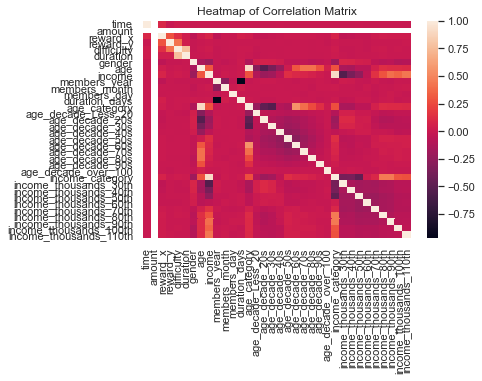

In [98]:
# Create a correlation matrix.
corr = df_all.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

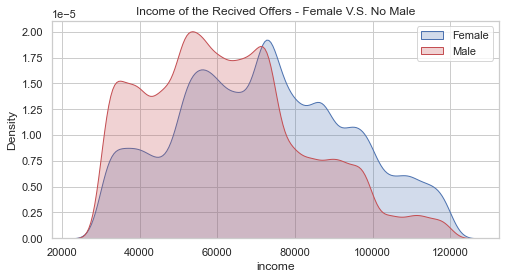

In [99]:
#KDEPlot: Kernel Density Income Plot
fig = plt.figure(figsize=(8,4))
ax=sns.kdeplot(df_all.loc[(df_all['gender'] == 0),'income'] , color='b',shade=True, label='Female')
ax=sns.kdeplot(df_all.loc[(df_all['gender'] == 1),'income'] , color='r',shade=True, label='Male')
plt.title('Income of the Recived Offers - Female V.S. No Male')
ax.legend()

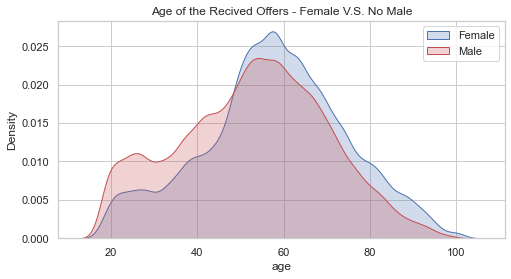

In [100]:
#KDEPlot: Kernel Density Age Plot
fig = plt.figure(figsize=(8,4))
ax=sns.kdeplot(df_all.loc[(df_all['gender'] == 0),'age'] , color='b',shade=True, label='Female')
ax=sns.kdeplot(df_all.loc[(df_all['gender'] == 1),'age'] , color='r',shade=True, label='Male')
plt.title('Age of the Recived Offers - Female V.S. No Male')
ax.legend()

## 1.Offer_type vs. Age_category

In [101]:
df_offer_agecat=df_all.copy()

In [102]:
# counting Offer_type vs. Age_category
df_offer_agecat.groupby(['age_category','offer_type'])['age'].count()

age_category  offer_type
0             0             13504
              1             13240
              2              4896
1             0             26164
              1             25305
              2              9338
2             0             24166
              1             23766
              2              8426
Name: age, dtype: int64

In [103]:
#Mapping Age_category and Offer_type
mapping_age_cat={'0': 'young', '1': 'adult','2': 'senior'}
mapping_offer_type={'0': 'BOGO', '1': 'Discount','2': 'Informational'}

In [104]:
#labeling the Age_category
df_offer_agecat['age_category']=df_offer_agecat['age_category'].astype(str).map(mapping_age_cat)

In [105]:
#labeling the Offer_type 
df_offer_agecat['offer_type']=df_offer_agecat['offer_type'].astype(str).map(mapping_offer_type)

In [106]:
# counting Offer_type vs. Age_category
df_offer_agecat.groupby(['age_category','offer_type'])['age'].count()

age_category  offer_type   
adult         BOGO             26164
              Discount         25305
              Informational     9338
senior        BOGO             24166
              Discount         23766
              Informational     8426
young         BOGO             13504
              Discount         13240
              Informational     4896
Name: age, dtype: int64

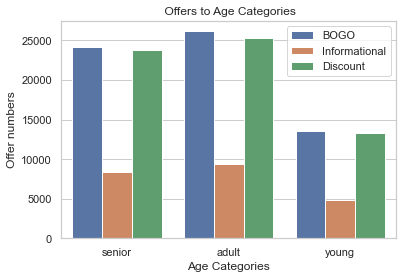

In [107]:
# Depicting a barplot of  Age_category based on Offer_type
f=sns.countplot(x="age_category", hue="offer_type", data=df_offer_agecat)
plt.title(' Offers to Age Categories')
plt.ylabel('Offer numbers')
plt.xlabel('Age Categories')
xlabels = ['senior','adult','young']
f.set_xticklabels(xlabels)
plt.legend(['BOGO','Informational','Discount'])
plt.show()

## 2.Offer_type vs. Gender

In [108]:
df_offer_gender=df_all.copy()

In [109]:
# counting Offer_type vs. gender
df_offer_gender.groupby(['gender','offer_type'])['age'].count()

gender  offer_type
0       0             27619
        1             26652
        2              9448
1       0             35301
        1             34739
        2             12856
2       0               914
        1               920
        2               356
Name: age, dtype: int64

In [110]:
#Mapping gender
mapping_gender={'0': 'Female', '1': 'Male','2': 'N/A'}

In [111]:
df_offer_gender.head()

,customer_id,event,time,offer_id,amount,reward_x,reward_y,difficulty,duration,offer_type,...,income_category,income_thousands_30th,income_thousands_40th,income_thousands_50th,income_thousands_60th,income_thousands_70th,income_thousands_80th,income_thousands_90th,income_thousands_100th,income_thousands_110th
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,1,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
5,78afa995795e4d85b5d9ceeca43f5fef,0,168,5a8bc65990b245e5a138643cd4eb9837,0,0,0.0,0.0,3.0,2,...,2,0,0,0,0,0,0,0,1,0
6,78afa995795e4d85b5d9ceeca43f5fef,0,216,5a8bc65990b245e5a138643cd4eb9837,0,0,0.0,0.0,3.0,2,...,2,0,0,0,0,0,0,0,1,0


In [112]:
#labeling the gender
df_offer_gender['gender']=df_offer_gender['gender'].astype(str).map(mapping_gender)

In [113]:
#labeling the offer_type
df_offer_gender['offer_type']=df_offer_gender['offer_type'].astype(str).map(mapping_offer_type)

In [114]:
# counting Offer_type vs. gender
df_offer_gender.groupby(['gender','offer_type'])['age'].count()

gender  offer_type   
Female  BOGO             27619
        Discount         26652
        Informational     9448
Male    BOGO             35301
        Discount         34739
        Informational    12856
N/A     BOGO               914
        Discount           920
        Informational      356
Name: age, dtype: int64

In [115]:
# keeping just Male and Female genders
df_offer_gender=df_offer_gender[(df_offer_gender['gender']=='Female')|(df_offer_gender['gender']=='Male')]

In [116]:
# counting Offer_type vs. gender
df_offer_gender.groupby(['gender','offer_type'])['age'].count()

gender  offer_type   
Female  BOGO             27619
        Discount         26652
        Informational     9448
Male    BOGO             35301
        Discount         34739
        Informational    12856
Name: age, dtype: int64

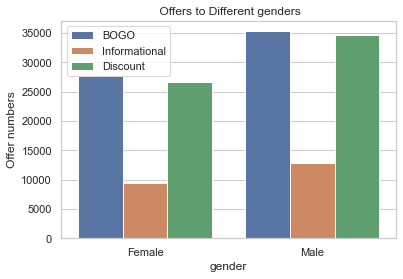

In [117]:
# Depicting a barplot of  gender based on Offer_type
f=sns.countplot(x="gender", hue="offer_type", data=df_offer_gender)
plt.title(' Offers to Different genders')
plt.ylabel('Offer numbers')
plt.xlabel('gender')
xlabels = ['Female','Male']
f.set_xticklabels(xlabels)
plt.legend(['BOGO','Informational','Discount'])
plt.show()

## 3.Offer_type vs. income_category

In [118]:
df_offer_income=df_all.copy()

In [119]:
df_offer_income

,customer_id,event,time,offer_id,amount,reward_x,reward_y,difficulty,duration,offer_type,...,income_category,income_thousands_30th,income_thousands_40th,income_thousands_50th,income_thousands_60th,income_thousands_70th,income_thousands_80th,income_thousands_90th,income_thousands_100th,income_thousands_110th
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,1,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
5,78afa995795e4d85b5d9ceeca43f5fef,0,168,5a8bc65990b245e5a138643cd4eb9837,0,0,0.0,0.0,3.0,2,...,2,0,0,0,0,0,0,0,1,0
6,78afa995795e4d85b5d9ceeca43f5fef,0,216,5a8bc65990b245e5a138643cd4eb9837,0,0,0.0,0.0,3.0,2,...,2,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,9fcbff4f8d7241faa4ab8a9d19c8a812,0,504,3f207df678b143eea3cee63160fa8bed,0,0,0.0,0.0,4.0,2,...,2,0,0,0,0,0,0,1,0,0
272758,9fcbff4f8d7241faa4ab8a9d19c8a812,0,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10.0,10.0,5.0,0,...,2,0,0,0,0,0,0,1,0,0
272759,9fcbff4f8d7241faa4ab8a9d19c8a812,0,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10.0,10.0,5.0,0,...,2,0,0,0,0,0,0,1,0,0
272760,3045af4e98794a04a5542d3eac939b1f,0,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10.0,10.0,5.0,0,...,1,0,0,0,0,1,0,0,0,0


In [120]:
# counting Offer_type vs. income_category
df_offer_income.groupby(['income_category','offer_type'])['age'].count()

income_category  offer_type
0                0             27381
                 1             26521
                 2             10193
1                0             19935
                 1             19771
                 2              7086
2                0             16518
                 1             16019
                 2              5381
Name: age, dtype: int64

In [121]:
#labeling the income_category
mapping_income={'0': 'low_income', '1': 'ave_income','2': 'high_income'}

In [122]:
#Mapping income_category
df_offer_income['income_category']=df_offer_income['income_category'].astype(str).map(mapping_income)

In [123]:
#Mapping offer_type
df_offer_income['offer_type']=df_offer_income['offer_type'].astype(str).map(mapping_offer_type)

In [124]:
# counting Offer_type vs. income_category
df_offer_income.groupby(['income_category','offer_type'])['age'].count()

income_category  offer_type   
ave_income       BOGO             19935
                 Discount         19771
                 Informational     7086
high_income      BOGO             16518
                 Discount         16019
                 Informational     5381
low_income       BOGO             27381
                 Discount         26521
                 Informational    10193
Name: age, dtype: int64

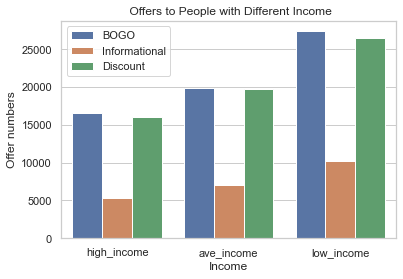

In [125]:
# Depicting a barplot of  income_category based on Offer_type
f=sns.countplot(x="income_category", hue="offer_type", data=df_offer_income)
plt.title(' Offers to People with Different Income')
plt.ylabel('Offer numbers')
plt.xlabel('Income')
xlabels = ['high_income','ave_income', 'low_income']
f.set_xticklabels(xlabels)
plt.legend(['BOGO','Informational','Discount'])
plt.show()

## 4.event vs. age_category

In [126]:
df_event_agecat=df_all.copy()

In [127]:
# counting event vs. age_category
df_event_agecat.groupby(['age_category','event'])['age'].count()

age_category  event
0             0        25501
              1         6139
1             0        47344
              1        13463
2             0        43516
              1        12842
Name: age, dtype: int64

In [128]:
#labeling the event
mapping_event={'0': 'offer', '1': 'offer_completed'}

In [129]:
#Mapping event, and age_category
df_event_agecat['event']=df_event_agecat['event'].astype(str).map(mapping_event)
df_event_agecat['age_category']=df_event_agecat['age_category'].astype(str).map(mapping_age_cat)

In [130]:
# counting event vs. age_category
df_event_agecat.groupby(['age_category','event'])['age'].count()

age_category  event          
adult         offer              47344
              offer_completed    13463
senior        offer              43516
              offer_completed    12842
young         offer              25501
              offer_completed     6139
Name: age, dtype: int64

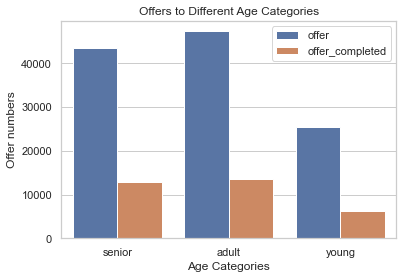

In [131]:
# Depicting a barplot of  age_category based on event
f=sns.countplot(x="age_category", hue="event", data=df_event_agecat)
plt.title('Offers to Different Age Categories')
plt.ylabel('Offer numbers')
plt.xlabel('Age Categories')
xlabels = ['senior','adult', 'young']
f.set_xticklabels(xlabels)
plt.legend(['offer','offer_completed'])
plt.show()

## 5.event vs. gender

In [132]:
df_event_gender=df_all.copy()

In [133]:
# counting event vs. gender
df_event_gender.groupby(['gender','event'])['age'].count()

gender  event
0       0        48242
        1        15477
1       0        66430
        1        16466
2       0         1689
        1          501
Name: age, dtype: int64

In [134]:
#Mapping event, and gender
df_event_gender['event']=df_event_gender['event'].astype(str).map(mapping_event)
df_event_gender['gender']=df_event_gender['gender'].astype(str).map(mapping_gender)

In [135]:
# counting event vs. gender
df_event_gender.groupby(['gender','event'])['age'].count()

gender  event          
Female  offer              48242
        offer_completed    15477
Male    offer              66430
        offer_completed    16466
N/A     offer               1689
        offer_completed      501
Name: age, dtype: int64

In [136]:
# keeping just female and male gender
df_event_gender=df_event_gender[(df_event_gender['gender']=='Female')|(df_event_gender['gender']=='Male')]

In [137]:
# counting event vs. gender
df_event_gender.groupby(['gender','event'])['age'].count()

gender  event          
Female  offer              48242
        offer_completed    15477
Male    offer              66430
        offer_completed    16466
Name: age, dtype: int64

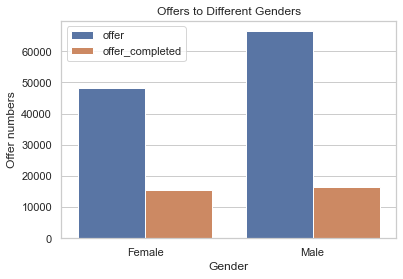

In [138]:
# Depicting a barplot of  gender based on event
f=sns.countplot(x="gender", hue="event", data=df_event_gender)
plt.title('Offers to Different Genders')
plt.ylabel('Offer numbers')
plt.xlabel('Gender')
xlabels = ['Female','Male']
f.set_xticklabels(xlabels)
plt.legend(['offer','offer_completed'])
plt.show()

## 6.event vs. income_category

In [139]:
df_event_income=df_all.copy()

In [140]:
# counting event vs. income_category
df_event_income.groupby(['income_category','event'])['age'].count()

income_category  event
0                0        51999
                 1        12096
1                0        36245
                 1        10547
2                0        28117
                 1         9801
Name: age, dtype: int64

In [141]:
#Mapping event, and income_category
df_event_income['event']=df_event_income['event'].astype(str).map(mapping_event)
df_event_income['income_category']=df_event_income['income_category'].astype(str).map(mapping_income)

In [142]:
# counting event vs. income_category
df_event_income.groupby(['income_category','event'])['age'].count()

income_category  event          
ave_income       offer              36245
                 offer_completed    10547
high_income      offer              28117
                 offer_completed     9801
low_income       offer              51999
                 offer_completed    12096
Name: age, dtype: int64

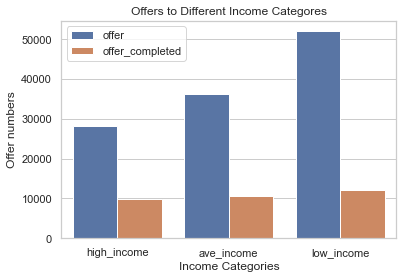

In [143]:
# Depicting a barplot of  income_category based on event 
f=sns.countplot(x="income_category", hue="event", data=df_event_income)
plt.title('Offers to Different Income Categores')
plt.ylabel('Offer numbers')
plt.xlabel('Income Categories')
xlabels = ['high_income','ave_income', 'low_income']
f.set_xticklabels(xlabels)
plt.legend(['offer','offer_completed'])
plt.show()

## 7. income vs age clustering based on completed offers

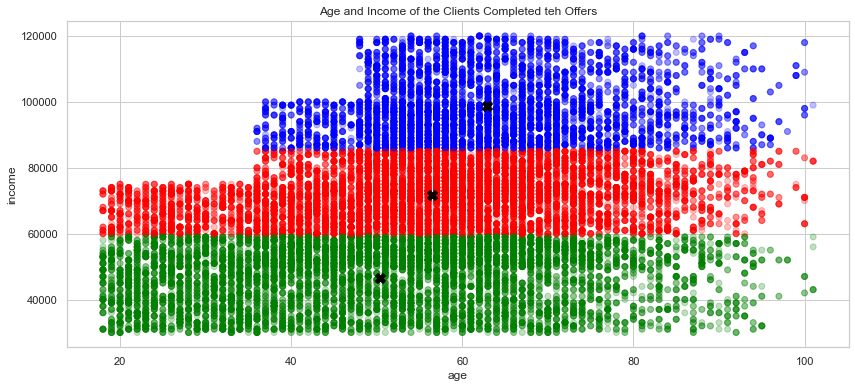

In [144]:
from sklearn.cluster import KMeans

# Graph and create 3 clusters of complted offers
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df_all[df_all.event==1][["age","income"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

fig = plt.figure(figsize=(14, 6))
plt.scatter(x="age",y="income", data=df_all[df_all.event==1],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("age")
plt.ylabel("income")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Age and Income of the Clients Completed teh Offers")
plt.show()

## 8.event vs year

In [145]:
#Preparing the data frame for the plot
Completed = df_all[df_all['event']==1]

Completed = pd.DataFrame(Completed.members_year.value_counts()).reset_index()
Completed_n = pd.DataFrame(df_all.members_year.value_counts()).reset_index()


Completed_merge = pd.merge(Completed, Completed_n, how='inner', on='index')

Completed_merge = Completed_merge.rename(columns={"members_year_x":'Offer_Completed', "members_year_y":'Offer', "index":'Membership_Year' })
Completed_merge

,Membership_Year,Offer_Completed,Offer
0,2017,12119,56063
1,2016,8928,32767
2,2018,5196,33877
3,2015,4319,16845
4,2014,1321,6553
5,2013,561,2700


In [146]:
#categorizing the type of Membership_Year
Completed_merge['Membership_Year']=Completed_merge['Membership_Year'].astype('str')

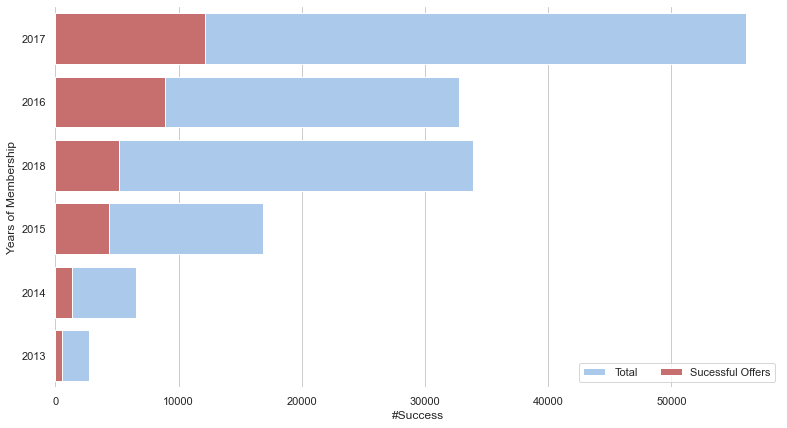

In [147]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the total offer per year
sns.set_color_codes("pastel")
sns.barplot(x="Offer", y='Membership_Year', data=Completed_merge,
            label="Total", color="b")

# Plot the total Offer_Completed schools per year
sns.set_color_codes("muted")
sns.barplot(x="Offer_Completed", y="Membership_Year", data=Completed_merge,
            label="Sucessful Offers", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Years of Membership",
       xlabel="#Success")

sns.despine(left=True, bottom=True)

## 9.gender vs members_year

In [148]:
df_year_gender=df_all.copy()

In [149]:
#counting gender vs members_year
df_year_gender.groupby(['members_year','gender'])['age'].count()

members_year  gender
2013          0           771
              1          1904
              2            25
2014          0          1378
              1          5146
              2            29
2015          0          7200
              1          9316
              2           329
2016          0         16478
              1         15938
              2           351
2017          0         25279
              1         29906
              2           878
2018          0         12613
              1         20686
              2           578
Name: age, dtype: int64

In [150]:
#mapping gender
df_year_gender['gender']=df_year_gender['gender'].astype(str).map(mapping_gender)

In [151]:
#counting gender vs members_year
df_year_gender.groupby(['members_year','gender'])['age'].count()

members_year  gender
2013          Female      771
              Male       1904
              N/A          25
2014          Female     1378
              Male       5146
              N/A          29
2015          Female     7200
              Male       9316
              N/A         329
2016          Female    16478
              Male      15938
              N/A         351
2017          Female    25279
              Male      29906
              N/A         878
2018          Female    12613
              Male      20686
              N/A         578
Name: age, dtype: int64

In [152]:
#keeping just female and male in gender
df_year_gender=df_year_gender[(df_year_gender['gender']=='Female')|(df_year_gender['gender']=='Male')]

In [153]:
#counting gender vs members_year
df_year_gender.groupby(['members_year','gender'])['age'].count()

members_year  gender
2013          Female      771
              Male       1904
2014          Female     1378
              Male       5146
2015          Female     7200
              Male       9316
2016          Female    16478
              Male      15938
2017          Female    25279
              Male      29906
2018          Female    12613
              Male      20686
Name: age, dtype: int64

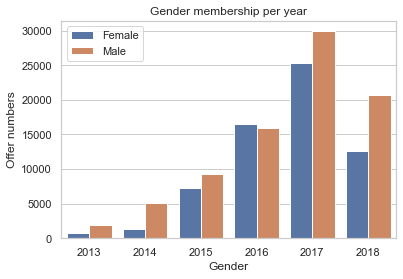

In [154]:
# Depicting a barplot of  member ship year based on gender 
f=sns.countplot(x="members_year", hue="gender", data=df_year_gender)
plt.title('Gender membership per year')
plt.ylabel('Offer numbers')
plt.xlabel('Gender')
#f.set_xticklabels(xlabels)
plt.legend(['Female','Male'])
plt.show()

## 10.offer_ids vs offer completion

In [155]:
#Preparing the data frame for the plot
Completed2 = df_all[df_all['event']==1]

Completed2 = pd.DataFrame(Completed2.offer_id.value_counts()).reset_index()
Completed_n2 = pd.DataFrame(df_all.offer_id.value_counts()).reset_index()


Completed_merge2 = pd.merge(Completed2, Completed_n2, how='inner', on='index')

Completed_merge2 = Completed_merge2.rename(columns={"offer_id_x":'Offer_Completed', "offer_id_y":'Offer', "index":'offer_id' })
Completed_merge2

,offer_id,Offer_Completed,Offer
0,fafdcd668e3743c1bb461111dcafc2a4,5003,18062
1,2298d6c36e964ae4a3e7e9706d1fb8c2,4886,17920
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,4188,14372
3,f19421c1d4aa40978ebb69ca19b0e20d,4103,16989
4,2906b810c7d4411798c6938adc9daaa5,3911,14002
5,ae264e3637204a6fb9bb56bc8210ddfd,3657,16241
6,0b1e1539f2cc45b7b9fa7c272da2e1d7,3386,12327
7,4d5c57ea9a6940dd891ad53e9dbe8da0,3310,16232


In [156]:
#categorizing  the offer ids
mapping_offer_id = Completed_merge2['offer_id'].astype('category')

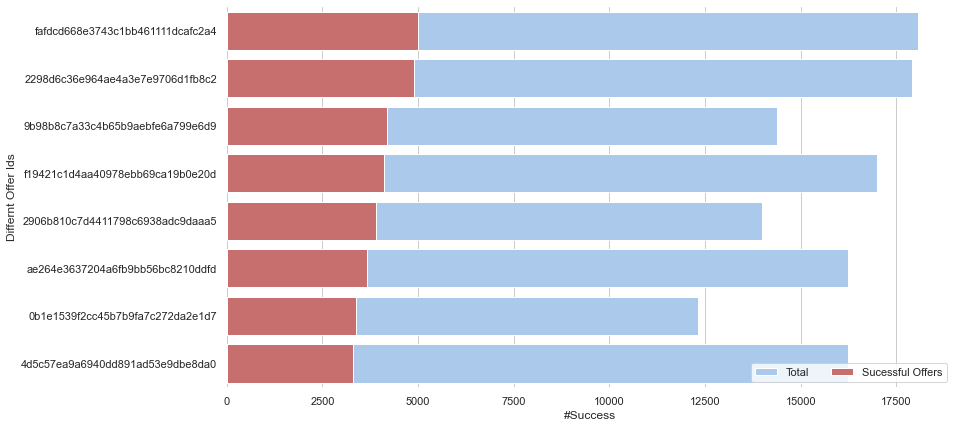

In [157]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the total offer per offer id
sns.set_color_codes("pastel")
sns.barplot(x="Offer", y='offer_id', data=Completed_merge2,
            label="Total", color="b")

# Plot the total offer completion schools per offer id
sns.set_color_codes("muted")
sns.barplot(x="Offer_Completed", y="offer_id", data=Completed_merge2,
            label="Sucessful Offers", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Differnt Offer Ids",
       xlabel="#Success")

sns.despine(left=True, bottom=True)

## 11.offer_types vs offer completion

In [158]:
#Preparing the data frame for the plot
Completed3 = df_all[df_all['event']==1]

Completed3 = pd.DataFrame(Completed3.offer_type.value_counts()).reset_index()
Completed_n3 = pd.DataFrame(df_all.offer_type.value_counts()).reset_index()


Completed_merge3 = pd.merge(Completed3, Completed_n3, how='inner', on='index')

Completed_merge3 = Completed_merge3.rename(columns={"offer_type_x":'Offer_Completed', "offer_type_y":'Offer', "index":'offer_type' })
Completed_merge3

,offer_type,Offer_Completed,Offer
0,1,17186,62311
1,0,15258,63834
2,2,0,22660


In [159]:
#categorizing the type of offer types
mapping_offer_type={'0': 'BOGO', '1': 'Discount','2': 'Informational'}
Completed_merge3['offer_type']=Completed_merge3['offer_type'].astype('str').map(mapping_offer_type)

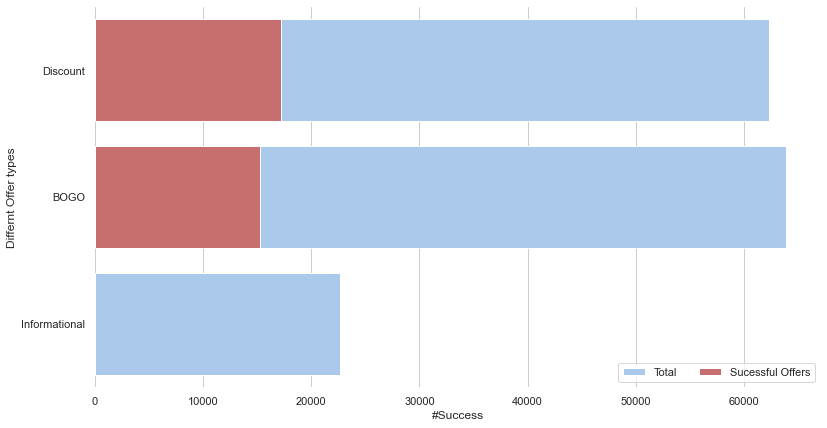

In [160]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the total offer per offer type
sns.set_color_codes("pastel")
sns.barplot(x="Offer", y='offer_type', data=Completed_merge3,
            label="Total", color="b")

# Plot the total offer completion schools per offer type
sns.set_color_codes("muted")
sns.barplot(x="Offer_Completed", y="offer_type", data=Completed_merge3,
            label="Sucessful Offers", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Differnt Offer types",
       xlabel="#Success")

sns.despine(left=True, bottom=True)

# Data Modeling

In [161]:
#Joining the data this time with impution
df_all=transcript_cleaning.merge(portfolio_cleaning, how='left', on= "offer_id").merge(profile_cleaning, on= "customer_id" )

In [162]:
#using mode for categorical data
fill_mod = lambda col: col.fillna(col.mode()[0])
# Fill the mean
df_all = df_all.apply(fill_mod, axis=0)

In [163]:
df_all

,customer_id,event,time,offer_id,amount,reward_x,reward_y,difficulty,duration,offer_type,...,income_category,income_thousands_30th,income_thousands_40th,income_thousands_50th,income_thousands_60th,income_thousands_70th,income_thousands_80th,income_thousands_90th,income_thousands_100th,income_thousands_110th
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,0,132,N/A,19,0,5.0,10.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,1,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5.0,5.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
4,78afa995795e4d85b5d9ceeca43f5fef,0,144,N/A,17,0,5.0,10.0,7.0,0,...,2,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,9fcbff4f8d7241faa4ab8a9d19c8a812,0,504,3f207df678b143eea3cee63160fa8bed,0,0,0.0,0.0,4.0,2,...,2,0,0,0,0,0,0,1,0,0
272758,9fcbff4f8d7241faa4ab8a9d19c8a812,0,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10.0,10.0,5.0,0,...,2,0,0,0,0,0,0,1,0,0
272759,9fcbff4f8d7241faa4ab8a9d19c8a812,0,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10.0,10.0,5.0,0,...,2,0,0,0,0,0,0,1,0,0
272760,3045af4e98794a04a5542d3eac939b1f,0,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10.0,10.0,5.0,0,...,1,0,0,0,0,1,0,0,0,0


In [164]:
#checking the Nans
df_all.isnull().sum()

customer_id               0
event                     0
time                      0
offer_id                  0
amount                    0
reward_x                  0
reward_y                  0
difficulty                0
duration                  0
offer_type                0
email                     0
mobile                    0
social                    0
web                       0
gender                    0
age                       0
income                    0
members_year              0
members_month             0
members_day               0
duration_days             0
age_category              0
age_decade_Less_20        0
age_decade_20s            0
age_decade_30s            0
age_decade_40s            0
age_decade_50s            0
age_decade_60s            0
age_decade_70s            0
age_decade_80s            0
age_decade_90s            0
age_decade_over_100       0
income_category           0
income_thousands_30th     0
income_thousands_40th     0
income_thousands_50t

In [165]:
#checking the columns
df_all.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward_x',
       'reward_y', 'difficulty', 'duration', 'offer_type', 'email', 'mobile',
       'social', 'web', 'gender', 'age', 'income', 'members_year',
       'members_month', 'members_day', 'duration_days', 'age_category',
       'age_decade_Less_20', 'age_decade_20s', 'age_decade_30s',
       'age_decade_40s', 'age_decade_50s', 'age_decade_60s', 'age_decade_70s',
       'age_decade_80s', 'age_decade_90s', 'age_decade_over_100',
       'income_category', 'income_thousands_30th', 'income_thousands_40th',
       'income_thousands_50th', 'income_thousands_60th',
       'income_thousands_70th', 'income_thousands_80th',
       'income_thousands_90th', 'income_thousands_100th',
       'income_thousands_110th'],
      dtype='object')

In [166]:
#types of the data
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   customer_id             272762 non-null  object  
 1   event                   272762 non-null  category
 2   time                    272762 non-null  int64   
 3   offer_id                272762 non-null  object  
 4   amount                  272762 non-null  int64   
 5   reward_x                272762 non-null  int64   
 6   reward_y                272762 non-null  float64 
 7   difficulty              272762 non-null  float64 
 8   duration                272762 non-null  float64 
 9   offer_type              272762 non-null  category
 10  email                   272762 non-null  category
 11  mobile                  272762 non-null  category
 12  social                  272762 non-null  category
 13  web                     272762 non-null  category
 14  gend

In [167]:
#renaming the reward
df_all.rename(columns ={'reward_x':'reward'}, inplace = True)

In [168]:
#after joining, we can turn the offer_id to categorical to use it in the model
df_all["offer_id"]=df_all["offer_id"].astype('category')
df_all["offer_id"] = df_all["offer_id"].cat.codes

In [169]:
#checking the event
df_all.event.value_counts(1)

0    0.881054
1    0.118946
Name: event, dtype: float64

## Imbalance data

Text(0, 0.5, 'Count')

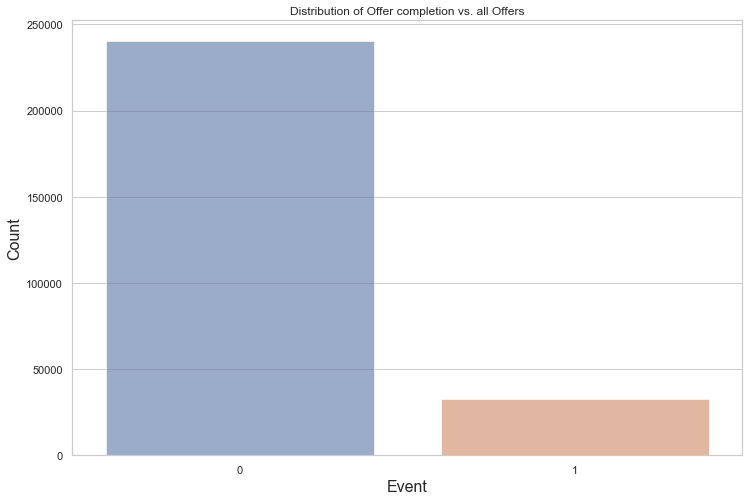

In [170]:
#Outlining the counts os Offer completion vs. all Offers
plt.figure(figsize=(12,8))
ev = df_all.event.value_counts()
sns.barplot(y=ev.values, x=ev.index, alpha=0.6)
plt.title('Distribution of Offer completion vs. all Offers')
plt.xlabel('Event', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [171]:
#choosing the X and Y variable
X = df_all.drop(['customer_id', 'event','reward_y'], axis=1)
Y = df_all['event']

In [172]:
X.head()

,time,offer_id,amount,reward,difficulty,duration,offer_type,email,mobile,social,...,income_category,income_thousands_30th,income_thousands_40th,income_thousands_50th,income_thousands_60th,income_thousands_70th,income_thousands_80th,income_thousands_90th,income_thousands_100th,income_thousands_110th
0,0,6,0,0,5.0,7.0,0,1,1,0,...,2,0,0,0,0,0,0,0,1,0
1,6,6,0,0,5.0,7.0,0,1,1,0,...,2,0,0,0,0,0,0,0,1,0
2,132,7,19,0,10.0,7.0,0,1,1,1,...,2,0,0,0,0,0,0,0,1,0
3,132,6,0,5,5.0,7.0,0,1,1,0,...,2,0,0,0,0,0,0,0,1,0
4,144,7,17,0,10.0,7.0,0,1,1,1,...,2,0,0,0,0,0,0,0,1,0


In [173]:
Y.head()

0    0
1    0
2    0
3    1
4    0
Name: event, dtype: category
Categories (2, int64): [0, 1]

In [174]:
X.shape , Y.shape

((272762, 39), (272762,))

## Feature Scaling 

StandardScaler removes the mean and scales the data to unit variance. However, the outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values as shown in the left figure below. Note in particular that because the outliers on each feature have different magnitudes, the spread of the transformed data on each feature is very different: most of the data lie in the [-2, 4] range for the transformed median income feature while the same data is squeezed in the smaller [-0.2, 0.2] range for the transformed number of households.

StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.

MinMaxScaler rescales the data set such that all feature values are in the range [0, 1] as shown in the right panel below. However, this scaling compress all inliers in the narrow range [0, 0.005] for the transformed number of households.

In [175]:
# normalizing some numerical values 
scaler = MinMaxScaler()
features = ['time', 'amount', 'reward', 'difficulty','duration','duration_days','age', 'income']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,time,offer_id,amount,reward,difficulty,duration,offer_type,email,mobile,social,...,income_category,income_thousands_30th,income_thousands_40th,income_thousands_50th,income_thousands_60th,income_thousands_70th,income_thousands_80th,income_thousands_90th,income_thousands_100th,income_thousands_110th
0,0.000000,6,0.000000,0.0,0.25,0.571429,0,1,1,0,...,2,0,0,0,0,0,0,0,1,0
1,0.008403,6,0.000000,0.0,0.25,0.571429,0,1,1,0,...,2,0,0,0,0,0,0,0,1,0
2,0.184874,7,0.017891,0.0,0.50,0.571429,0,1,1,1,...,2,0,0,0,0,0,0,0,1,0
3,0.184874,6,0.000000,0.5,0.25,0.571429,0,1,1,0,...,2,0,0,0,0,0,0,0,1,0
4,0.201681,7,0.016008,0.0,0.50,0.571429,0,1,1,1,...,2,0,0,0,0,0,0,0,1,0


In [176]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y,test_size=0.20, random_state=123)

In [177]:
X_train.shape, X_test.shape

((218209, 39), (54553, 39))

In [178]:
# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)

X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))


# Upsample using SMOTE
sm = SMOTE(random_state=12)
x_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)


# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))


print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print ("SMOTE sample shape:", x_train_sm.shape, y_train_sm.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (218209, 39) (218209,)
Upsampled shape: (384384, 39) (384384,)
SMOTE sample shape: (384384, 39) (384384,)
Downsampled shape: (52034, 39) (52034,)


In [179]:
# Create the Original, Upsampled, and Downsampled training sets
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "SMOTE":(x_train_sm, y_train_sm),
                "Downsampled": (X_train_d, y_train_d)}

# Loop through each type of training sets and apply 5-Fold CV using Logistic Regression
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=5, scoring='f1')
    print(f"The best F1 Score for {method} data:")
    print (lr_results.mean())
 
cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=5, scoring='f1').mean()

c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
  

The best F1 Score for Original data:
0.8942752628884874


c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
  

The best F1 Score for Upsampled data:
0.9589973832596899


c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1346, in fit
    accept_large_sparse=solver != 'liblinear')
  File "c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    r

The best F1 Score for SMOTE data:
nan


c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
  

The best F1 Score for Downsampled data:
0.9524958718868483


c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
  

0.7755288337124056

It sounds that either upsampling or down sampling will provide us with better resulyts. I use here dowsampling

## 1.Logistic Regression

In [180]:
lr = LogisticRegression()

# Fit the model to the Downsampling data
lr = lr.fit(X_train_d, y_train_d)

print ("\n\n ---Logistic Regression Model---")
lr_auc = roc_auc_score(y_test, lr.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

lr2 = lr.fit(X_train_d, y_train_d)
print(classification_report(y_test, lr.predict(X_test)))

c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)




 ---Logistic Regression Model---
Logistic Regression AUC = 0.94
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     48126
           1       0.63      0.96      0.76      6427

    accuracy                           0.93     54553
   macro avg       0.81      0.94      0.86     54553
weighted avg       0.95      0.93      0.93     54553



c:\users\mfardhossein\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 1.1.Logistic Regression Confusion Matrix

In [181]:
# Confusion Matrix for Logistic Regresion
confusion_matrix(y_test, lr.predict(X_test))

array([[44433,  3693],
       [  244,  6183]], dtype=int64)

Confusion matrix, without normalization Logistic Regression
[[44433  3693]
 [  244  6183]]
Normalized confusion matrix Logistic Regression
[[0.92326393 0.07673607]
 [0.03796484 0.96203516]]


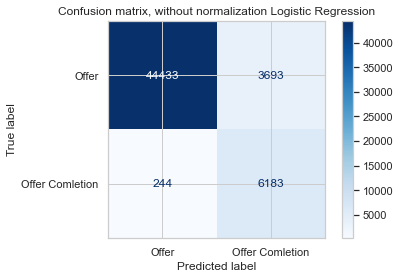

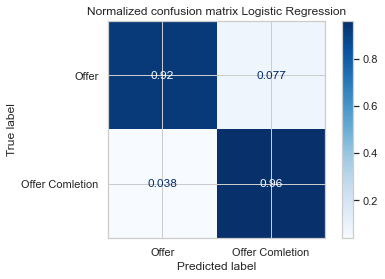

In [182]:
# Confusion Matrix for Logistic Regresion
titles_options = [("Confusion matrix, without normalization Logistic Regression", None),
                  ("Normalized confusion matrix Logistic Regression", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=['Offer','Offer Comletion'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## 2.Random Forest

In [183]:
# Random Forest Model using crossvalidation
rf = RandomForestClassifier()
rf_result = cross_val_score(rf, X_train_d, y_train_d, cv=5, scoring='f1')
rf_result.mean()

1.0

In [184]:
rf = rf.fit(X_train_d, y_train_d)

print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48126
           1       1.00      1.00      1.00      6427

    accuracy                           1.00     54553
   macro avg       1.00      1.00      1.00     54553
weighted avg       1.00      1.00      1.00     54553



### 2.1.Random Forest Confusion Matrix

In [185]:
# Confusion Matrix for Random Forest
confusion_matrix(y_test, rf.predict(X_test))

array([[48126,     0],
       [    0,  6427]], dtype=int64)

Confusion matrix, without normalization Random Forest
[[48126     0]
 [    0  6427]]
Normalized confusion matrix Random Forest
[[1. 0.]
 [0. 1.]]


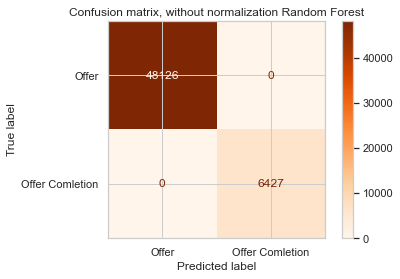

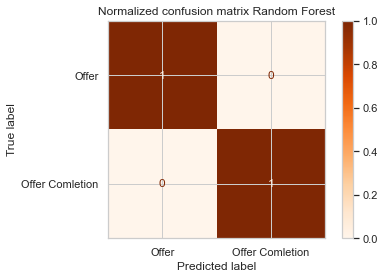

In [217]:
# Confusion Matrix for Random Forest
titles_options = [("Confusion matrix, without normalization Random Forest", None),
                  ("Normalized confusion matrix Random Forest", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, X_test, y_test,
                                 display_labels=['Offer','Offer Comletion'],
                                 cmap=plt.cm.Oranges,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## 3.Gradient Boosting

In [187]:
# Gradient Boosting Model using crossvalidation
gbc = GradientBoostingClassifier()  
gbc = gbc.fit(X_train_d, y_train_d)
gbc_result = cross_val_score(gbc, X_train_d, y_train_d, cv=5, scoring='f1')
gbc_result.mean()

1.0

In [188]:
print ("\n\n ---Gradient Boosting Model---")
gbc_auc = roc_auc_score(y_test, gbc.predict(X_test))
print ("Gradient Boosting Classifier AUC = %2.2f" % gbc_auc)
print(classification_report(y_test, gbc.predict(X_test)))



 ---Gradient Boosting Model---
Gradient Boosting Classifier AUC = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48126
           1       1.00      1.00      1.00      6427

    accuracy                           1.00     54553
   macro avg       1.00      1.00      1.00     54553
weighted avg       1.00      1.00      1.00     54553



### 3.1.Gradient Boosting Confusion Matrix

In [189]:
# Confusion Matrix for Gradient Boosting
confusion_matrix(y_test, gbc.predict(X_test))

array([[48126,     0],
       [    0,  6427]], dtype=int64)

Confusion matrix, without normalization Gradient Boosting
[[48126     0]
 [    0  6427]]
Normalized confusion matrix Gradient Boosting
[[1. 0.]
 [0. 1.]]


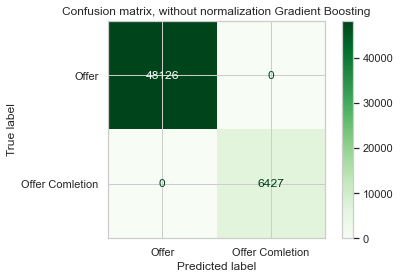

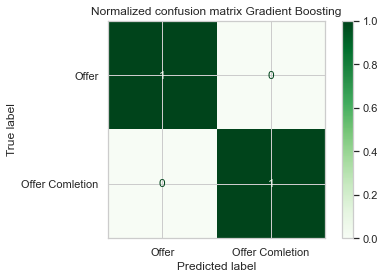

In [218]:
# Confusion Matrix for Gradient Boosting
titles_options = [("Confusion matrix, without normalization Gradient Boosting", None),
                  ("Normalized confusion matrix Gradient Boosting", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gbc, X_test, y_test,
                                 display_labels=['Offer','Offer Comletion'],
                                 cmap=plt.cm.Greens,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## 4.Support Vector Machine

In [191]:
# Support Vector Machine Model using crossvalidation
SVM=SVC(kernel= "linear",probability=True)
SVM.fit(X_train_d, y_train_d)
SVM_result = cross_val_score(SVM, X_train_d, y_train_d, cv=5, scoring='f1')
SVM_result.mean()

1.0

In [192]:
print ("\n\n ---Support Vector Machine---")
SVM_auc = roc_auc_score(y_test, SVM.predict(X_test))
print ("Support Vector Machine Classifier AUC = %2.2f" % SVM_auc)
print(classification_report(y_test, SVM.predict(X_test)))



 ---Support Vector Machine---
Support Vector Machine Classifier AUC = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48126
           1       1.00      1.00      1.00      6427

    accuracy                           1.00     54553
   macro avg       1.00      1.00      1.00     54553
weighted avg       1.00      1.00      1.00     54553



## 4.1.Support Vector Machine Confusion Matrix

Confusion matrix, without normalization SVM
[[48126     0]
 [    0  6427]]
Normalized confusion matrix SVM
[[1. 0.]
 [0. 1.]]


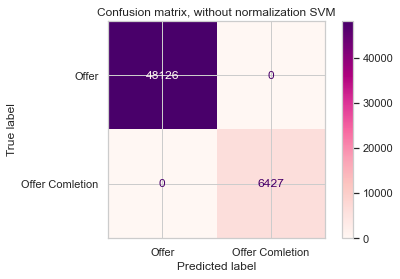

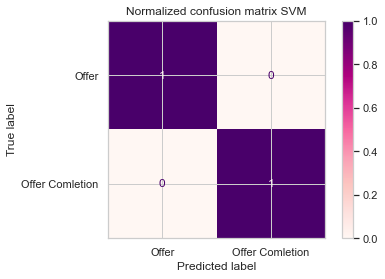

In [220]:
# Confusion Matrix for SVM
titles_options = [("Confusion matrix, without normalization SVM", None),
                  ("Normalized confusion matrix SVM", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(SVM, X_test, y_test,
                                 display_labels=['Offer','Offer Comletion'],
                                 cmap=plt.cm.RdPu,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## 5.Decision Tree

In [194]:
# Decision Tree Machine Model using crossvalidation
Dt=DecisionTreeClassifier()
Dt.fit(X_train_d, y_train_d)
Dt_result = cross_val_score(Dt, X_train_d, y_train_d, cv=5, scoring='f1')
Dt_result.mean()

1.0

In [195]:
print ("\n\n ---Decision Tree Classifier---")
Dt_auc = roc_auc_score(y_test, Dt.predict(X_test))
print ("Decision Tree Classifier AUC = %2.2f" % Dt_auc)
print(classification_report(y_test, Dt.predict(X_test)))



 ---Decision Tree Classifier---
Decision Tree Classifier AUC = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48126
           1       1.00      1.00      1.00      6427

    accuracy                           1.00     54553
   macro avg       1.00      1.00      1.00     54553
weighted avg       1.00      1.00      1.00     54553



## 5.1.Decision Tree Confusion Matrix

Confusion matrix, without normalization Decision Tree
[[48126     0]
 [    0  6427]]
Normalized confusion matrix Decision Tree
[[1. 0.]
 [0. 1.]]


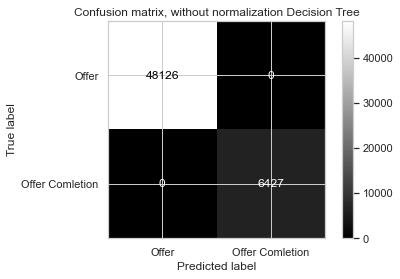

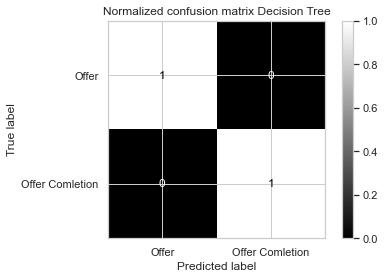

In [221]:
# Confusion Matrix for Decision Tree
titles_options = [("Confusion matrix, without normalization Decision Tree", None),
                  ("Normalized confusion matrix Decision Tree", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(Dt, X_test, y_test,
                                 display_labels=['Offer','Offer Comletion'],
                                 cmap=plt.cm.gray,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## 6.GussianNB

In [197]:
# GussianNB Machine Model using crossvalidation
gnb = GaussianNB()
gnb.fit(X_train_d, y_train_d)
gnb_result = cross_val_score(gnb, X_train_d, y_train_d, cv=5, scoring='f1')
gnb_result.mean()


0.965454650720414

In [198]:
print ("\n\n ---Gussian Classifier---")
gnb_auc = roc_auc_score(y_test, gnb.predict(X_test))
print ("Gussian Classifier Classifier AUC = %2.2f" % gnb_auc)
print(classification_report(y_test, gnb.predict(X_test)))



 ---Gussian Classifier---
Gussian Classifier Classifier AUC = 0.96
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     48126
           1       0.64      1.00      0.78      6427

    accuracy                           0.94     54553
   macro avg       0.82      0.96      0.87     54553
weighted avg       0.96      0.94      0.94     54553



## 6.1.Gussian Confusion Matrix

Confusion matrix, without normalization GussianNB
[[44587  3539]
 [    0  6427]]
Normalized confusion matrix GussianNB
[[0.92646387 0.07353613]
 [0.         1.        ]]


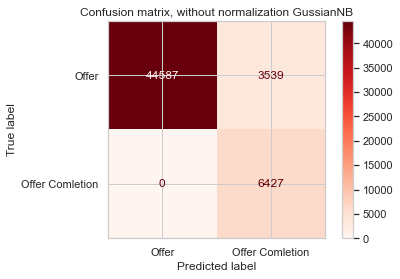

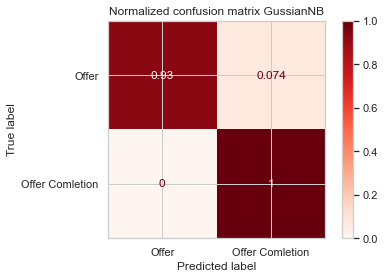

In [222]:
# Confusion Matrix for Gussian
titles_options = [("Confusion matrix, without normalization GussianNB", None),
                  ("Normalized confusion matrix GussianNB", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gnb, X_test, y_test,
                                 display_labels=['Offer','Offer Comletion'],
                                 cmap=plt.cm.Reds,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## 7.K Nearest Neighbour

In [200]:
# K Nearest Neighbour Model using crossvalidation
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(X_train_d, y_train_d)
KNN_result = cross_val_score(KNN, X_train_d, y_train_d, cv=5, scoring='f1')
KNN_result.mean()

0.8033951339152224

In [201]:
print ("\n\n ---K Nearest Neighbour Classifier---")
KNN_auc = roc_auc_score(y_test, KNN.predict(X_test))
print ("K Nearest Neighbour Classifier Classifier AUC = %2.2f" % KNN_auc)
print(classification_report(y_test, KNN.predict(X_test)))



 ---K Nearest Neighbour Classifier---
K Nearest Neighbour Classifier Classifier AUC = 0.79
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     48126
           1       0.30      0.83      0.44      6427

    accuracy                           0.75     54553
   macro avg       0.64      0.79      0.64     54553
weighted avg       0.89      0.75      0.79     54553



## 7.1.K Nearest Neighbour Confusion Matrix

Confusion matrix, without normalization K Nearest Neighbour
[[35642 12484]
 [ 1083  5344]]
Normalized confusion matrix K Nearest Neighbour
[[0.7405976  0.2594024 ]
 [0.16850786 0.83149214]]


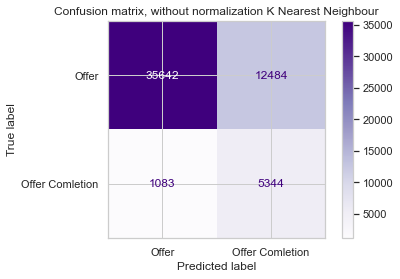

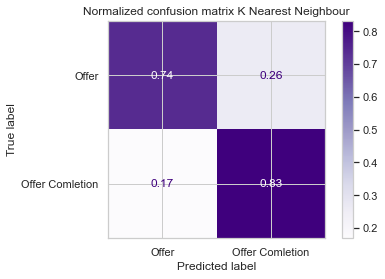

In [219]:
# Confusion Matrix for KNN
titles_options = [("Confusion matrix, without normalization K Nearest Neighbour", None),
                  ("Normalized confusion matrix K Nearest Neighbour", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(KNN, X_test, y_test,
                                 display_labels=['Offer','Offer Comletion'],
                                 cmap=plt.cm.Purples,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [231]:
## getting the accuracy, precision, and recall for all the models to place it in table
models = [lr, rf, gbc, SVM, Dt, gnb,KNN]
model_names = [type(n).__name__ for n in models]
models_accuracy = [accuracy_score(y_test, x.predict(X_test))*100 for x in models]
models_precision = [precision_score(y_test, x.predict(X_test))*100 for x in models]
models_recall = [recall_score(y_test, x.predict(X_test))*100 for x in models]

In [232]:
# developing the table 
results = [models_accuracy, models_precision,models_recall]
results_df = pd.DataFrame(results, columns = model_names, index=['Accuracy', 'Precision', 'Recall'])
results_df

,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier,SVC,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier
Accuracy,92.783165,100.0,100.0,100.0,100.0,93.512731,75.130607
Precision,62.606318,100.0,100.0,100.0,100.0,64.489263,29.975320
Recall,96.203516,100.0,100.0,100.0,100.0,100.000000,83.149214


## ROC Graph

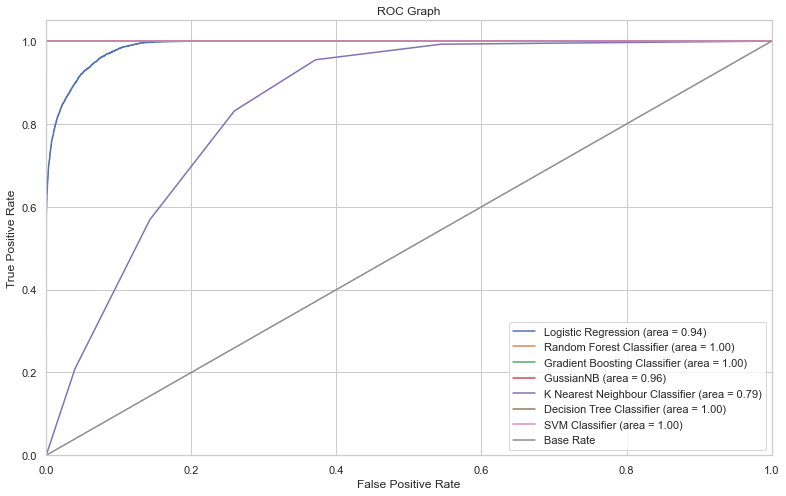

In [203]:
#Finding the fpr, tpr and tresholds for the classifires
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
gnb_fpr, gnb_tpr, gnb_thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
KNN_fpr, KNN_tpr, KNN_thresholds = roc_curve(y_test, KNN.predict_proba(X_test)[:,1])
Dt_fpr, Dt_tpr, Dt_thresholds = roc_curve(y_test, Dt.predict_proba(X_test)[:,1])
SVM_fpr, SVM_tpr, SVM_thresholds = roc_curve(y_test, SVM.predict_proba(X_test)[:,1])

plt.figure(figsize=(13,8))

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)

# Plot Decision Tree ROC
plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Classifier (area = %0.2f)' % gbc_auc)

# Plot Logistic GussianNB
plt.plot(gnb_fpr, gnb_tpr, label='GussianNB (area = %0.2f)' % gnb_auc)

# Plot Random Forest ROC
plt.plot(KNN_fpr, KNN_tpr, label='K Nearest Neighbour Classifier (area = %0.2f)' % KNN_auc)

# Plot Decision Tree ROC
plt.plot(Dt_fpr, Dt_tpr, label='Decision Tree Classifier (area = %0.2f)' % Dt_auc)

# Plot SVM ROC
plt.plot(SVM_fpr, SVM_tpr, label='SVM Classifier (area = %0.2f)' % SVM_auc)



# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [234]:
rf.predict_proba(X_test)[175:200]

array([[0.99, 0.01],
       [0.99, 0.01],
       [0.97, 0.03],
       [0.97, 0.03],
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.01, 0.99],
       [0.94, 0.06],
       [1.  , 0.  ],
       [0.98, 0.02],
       [0.91, 0.09],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.98, 0.02],
       [0.94, 0.06],
       [0.97, 0.03],
       [0.03, 0.97],
       [0.98, 0.02],
       [0.94, 0.06],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ]])

## Feature Importance

Among the above classifires, we choos random forest to find the most important feature 

In [204]:
# Get Feature Importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances

,index,importance
0,reward,0.712116
1,amount,0.097948
2,offer_id,0.054621
3,duration,0.030328
4,difficulty,0.024104
5,offer_type,0.021652
6,time,0.018044
7,duration_days,0.005664
8,social,0.005612
9,web,0.005330


<AxesSubplot:xlabel='importance', ylabel='index'>

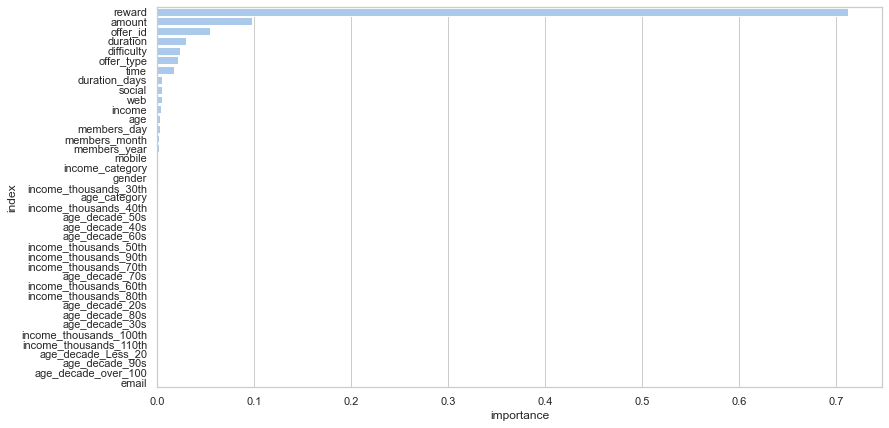

In [205]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances,
            label="Total", color="b")

## 8.Neural Network

In [212]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Activation

# Convert the target to categorical: target
target = to_categorical(y_train)
predictors= X_train.values
n_cols = predictors.shape[1]
# Set up the model
model = Sequential()

# Add the first layer
model.add(Dense(32, activation= 'relu', input_shape=(n_cols,)))
model.add(Dropout(.1))
model.add(Dense(100, activation= 'relu'))
model.add(Dropout(.25))
model.add(Dense(100, activation= 'relu'))
model.add(Dropout(.25))


# Add the output layer
model.add(Dense(2,activation= 'softmax'))

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model_1_training = model.fit(predictors, target, epochs=20, validation_split=0.4, verbose=True)





Epoch 1/20
4092/4092 [==============================] - 7s 2ms/step - loss: 45.9850 - accuracy: 0.8779 - val_loss: 0.3665 - val_accuracy: 0.8805
Epoch 2/20
4092/4092 [==============================] - 6s 2ms/step - loss: 0.3635 - accuracy: 0.8829 - val_loss: 0.3664 - val_accuracy: 0.8805
Epoch 3/20
4092/4092 [==============================] - 6s 2ms/step - loss: 0.3657 - accuracy: 0.8816 - val_loss: 0.3659 - val_accuracy: 0.8805
Epoch 4/20
4092/4092 [==============================] - 6s 2ms/step - loss: 0.3676 - accuracy: 0.8802 - val_loss: 0.3659 - val_accuracy: 0.8805
Epoch 5/20
4092/4092 [==============================] - 7s 2ms/step - loss: 0.3620 - accuracy: 0.8830 - val_loss: 0.3659 - val_accuracy: 0.8805
Epoch 6/20
4092/4092 [==============================] - 7s 2ms/step - loss: 0.3654 - accuracy: 0.8809 - val_loss: 0.3660 - val_accuracy: 0.8805
Epoch 7/20
4092/4092 [==============================] - 7s 2ms/step - loss: 0.3659 - accuracy: 0.8807 - val_loss: 0.3661 - val_accuracy

In [207]:
# Evaluate your model accuracy on the test set
accuracy = model.evaluate(X_test.values, to_categorical(y_test))[1]

# Print accuracy
print('Accuracy:', accuracy)

# Calculate predictions: predictions
predictions = model.predict(X_test.values)

# Calculate predicted probability of survival: predicted_prob_true
predicted_prob_true = predictions[:,1]

# print predicted_prob_true
print(predicted_prob_true)


1705/1705 [==============================] - 1s 714us/step - loss: 0.3626 - accuracy: 0.8822
Accuracy: 0.8821879625320435
[0.11902738 0.11902738 0.11902738 ... 0.11902738 0.11902738 0.11902738]


# Visualizing using PCS and Random Forest

In [208]:
dd=df_all[['reward','amount','offer_id','offer_type','duration','difficulty', 'time' ]]

In [209]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(dd.values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
Final_PCA=principalDf.values
print(pca.components_)
print(pca.explained_variance_)

[[-4.47612939e-04 -2.65795982e-03 -2.19295560e-04  1.40539791e-04
  -2.08468110e-04 -6.65177374e-04 -9.99996091e-01]
 [-7.31908552e-03  9.99767765e-01  1.29916439e-02 -4.83297446e-03
   2.60511675e-03  1.43109585e-02 -2.66766751e-03]]
[40144.07398325   503.32709217]


In [210]:
training_data, validation_data, training_labels, validation_labels = train_test_split(Final_PCA, Y.values, train_size = 0.8, test_size = 0.2, random_state = 100)
classifier_1=RandomForestClassifier()
classifier_1.fit(training_data, training_labels)
print(classifier_1.score(validation_data, validation_labels))

0.999890015214562


In [211]:
'''
sns.set_style('whitegrid')
sns.color_palette("pastel")

x_min, x_max = Final_PCA[:, 0].min() - 0.5, Final_PCA[:, 0].max() + 0.5
y_min, y_max = Final_PCA[:, 1].min() - 0.5, Final_PCA[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
f, axarr = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))



Z = classifier_1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr.contourf(xx, yy, Z,cmap=cm, alpha=0.4)
axarr.scatter(Final_PCA[:, 0], Final_PCA[:, 1], c=Y.values, s=30, edgecolor='k',cmap=cm_bright)
axarr.set_title('Random Forest', {'fontsize': 30})

plt.show()
'''

'\nsns.set_style(\'whitegrid\')\nsns.color_palette("pastel")\n\nx_min, x_max = Final_PCA[:, 0].min() - 0.5, Final_PCA[:, 0].max() + 0.5\ny_min, y_max = Final_PCA[:, 1].min() - 0.5, Final_PCA[:, 1].max() + 0.5\nxx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),\n                     np.arange(y_min, y_max, 0.1))\ncm = plt.cm.RdBu\ncm_bright = ListedColormap([\'#FF0000\', \'#0000FF\'])\nf, axarr = plt.subplots(1, 1, sharex=\'col\', sharey=\'row\', figsize=(10, 8))\n\n\n\nZ = classifier_1.predict(np.c_[xx.ravel(), yy.ravel()])\nZ = Z.reshape(xx.shape)\n\naxarr.contourf(xx, yy, Z,cmap=cm, alpha=0.4)\naxarr.scatter(Final_PCA[:, 0], Final_PCA[:, 1], c=Y.values, s=30, edgecolor=\'k\',cmap=cm_bright)\naxarr.set_title(\'Random Forest\', {\'fontsize\': 30})\n\nplt.show()\n'